Importing packages

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib
import torch
from matplotlib import pyplot as plt
from torch import nn
matplotlib.use('TkAgg')

Function definitions

In [2]:
# extracts data from an excel file
def data_extractor(column_values=None, filename='refrigerant_data.xlsx'):
    raw_data = pd.read_excel(filename)
    column_names = raw_data.columns.values
    column_values = []
    for i in range(0, len(raw_data.columns)):
        column_values.append(np.array(raw_data[raw_data.columns[i]].values))
    return column_names, column_values


# given a set of experimental label data and predicted label data, returns R^2 and AAD
def fit_evaluator(label, label_correlation):
    # print(label.shape)
    # print(label_correlation.shape)
    SS_residual = np.sum(np.square((label - label_correlation)))
    # print('ss residual is    {}'.format(SS_residual))
    SS_total = (len(label) - 1) * np.var(label,ddof=1)
    # print(len(label)), print(np.var(label,ddof=1))
    R_squared = 1 - (SS_residual / SS_total)
    AAD = 100 * ((1 / len(label)) * np.sum(abs(label - label_correlation) / label))
    return np.round(R_squared, decimals=2), np.round(AAD, decimals=2)


def matrix_to_tensor(array, data_range):
    frame = pd.DataFrame()
    for item in array:
        data = pd.DataFrame(item[data_range]).transpose()
        frame = frame.append(data)
    return torch.tensor(frame.transpose().values).float()


# prepares data for neural_network_trainer()
def nn_data_preparer(features, labels):
    sub_range_size = int(0.4 * len(labels[0]))
    training_range = random.sample(range(0, len(labels[0])), sub_range_size)
    test_range = random.sample(list(x for x in list(range(0, len(labels[0]))) if x not in training_range), sub_range_size)
    validation_range = list(z for z in list(range(0, len(labels[0]))) if z not in (training_range, test_range))
    X = matrix_to_tensor(features, range(0,len(features[0])))
    Y = matrix_to_tensor(labels, range(0,len(features[0])))
    return X, Y, training_range, test_range, validation_range


# creating a NeuralNet class and defining net properties to train a model to take features=>label
class NeuralNet(nn.Module):
    def __init__(self, input_neurons, output_neurons, hidden_neurons):
        super(NeuralNet, self).__init__()
        self.layer = nn.Sequential(
            nn.LeakyReLU(),
            nn.Linear(input_neurons, hidden_neurons),
            nn.LeakyReLU(),
            nn.Linear(hidden_neurons, hidden_neurons),
            nn.LeakyReLU(),
            nn.Linear(hidden_neurons, hidden_neurons),
            nn.LeakyReLU(),
            nn.Linear(hidden_neurons, hidden_neurons),
            nn.LeakyReLU(),
            nn.Linear(hidden_neurons, hidden_neurons),
            nn.LeakyReLU(),
            nn.Linear(hidden_neurons, output_neurons))

    def forward(self, x):
        x = self.layer(x)
        return x


# trains a neural network to predict y (prepared from label data) based on x (prepared from feature data)
def neural_network_trainer(x, y, training_range, hidden_neurons=32, learning_rate=0.005, epochs=30000):
    # setting model parameters
    input_neurons = x.shape[1]
    output_neurons = y.shape[1]
    x = x[training_range]
    y = y[training_range]
    model = NeuralNet(input_neurons, output_neurons, hidden_neurons)
    model.train()
    print(model)
    loss_func = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
    # x = Variable(x)
    # y = Variable(y)
    for epoch in range(epochs):
        y_pred = model(x)  # forward pass
        loss = loss_func(y_pred, y)  # computing loss
        loss.backward()  # backward pass
        optimizer.step()  # updating parameters
        optimizer.zero_grad()  # zeroing gradients
        # print('epoch: {}; loss: {}'.format(epoch, loss.item()))
        # plt.figure(1)
        # if loss.item() > 0:
        #     plt.ylim(0, 3*loss.item()), plt.xlim(0, epoch)
        # if epoch == epochs:
        #     print(loss.item())
        # plt.scatter(epoch, loss.item(), s=1)
        # plt.xlabel('Epoch'), plt.ylabel('Loss')
        if epoch % 100 == 0:  # plotting and showing learning process
            print('epoch: {}; loss: {}'.format(epoch, loss.item()))
            plt.figure(2)
            plt.clf()
            plt.scatter(x[:, 1].data.numpy(), y[:, 0].data.numpy(), color='orange', s=1)
            plt.scatter(x[:, 1].data.numpy(), y_pred[:, 0].data.numpy(), color='blue', s=1)
            plt.text(0.5, 0, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 10, 'color': 'red'})
            plt.xlabel('Reduced temperature'), plt.ylabel('Pressure /bar')
            # plt.scatter(y[:, 0].data.numpy(), y_pred[:, 0].data.numpy())
            # plt.plot(np.linspace(0, 5000000, 5), np.linspace(0, 5000000, 5))
            # plt.ylim((0, 5000000)), plt.xlim(0, 5000000)
            # plt.xlabel('Actual values')
            # plt.ylabel('Predicted values')
            plt.pause(0.0001)
    # plt.close('all')
    return model


# takes the trained neural network with accompanying data and evaluates the model based on subset of data
# can be used for testing and validation
def neural_network_evaluator(features, labels, d_range, model, x_label='Temperature /K',
                             y_label='Vapour pressure /Pa', test_label_index=0):
    model.eval()
    X = matrix_to_tensor(features, d_range)
    Y = matrix_to_tensor(labels, d_range)
    y_correlation = model(X)
    # R_sq, AAD = fit_evaluator(Y[test_label_index].data.numpy(), y_correlation[test_label_index].data.numpy())
    R_sq, AAD = 1, 1
    loss_func = torch.nn.MSELoss()
    validation_loss = loss_func(y_correlation, Y).item()
    plt.figure()
    plt.title('Testing neural network fit: validation data points')
    plt.scatter(X[:, 1].numpy(), Y[:,0].data.numpy(), color ='orange', s=1, label='Experimental data points')
    plt.scatter(X[:, 1].numpy(), y_correlation[:,0].data.numpy(), color='blue', s=1, label='ANN model \n R^2:{} AAD:{}'.format(R_sq, AAD))
    plt.xlabel('Reduced boiling temperature'), plt.ylabel('Pressure /bar')
    plt.legend()
    
    plt.figure()
    plt.title('Testing neural network fit: Predicted pressures for test compounds')
    plt.scatter(Y[:,0].data.numpy(), y_correlation[:,0].data.numpy(), s=1)
    plt.plot(np.linspace(0, 5000000/101300, 5), np.linspace(0, 5000000/101300, 5))
    plt.ylim((0, 5000000/101300)), plt.xlim(0, 5000000/101300)
    print(validation_loss)
    plt.text(0.5, 0, 'Loss=%.4f' % validation_loss, fontdict={'size': 10, 'color': 'red'})
    plt.xlabel('Actual values'), plt.ylabel('Predicted values')

Main body begins

NeuralNet(
  (layer): Sequential(
    (0): LeakyReLU(negative_slope=0.01)
    (1): Linear(in_features=6, out_features=32, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Linear(in_features=32, out_features=32, bias=True)
    (4): LeakyReLU(negative_slope=0.01)
    (5): Linear(in_features=32, out_features=32, bias=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Linear(in_features=32, out_features=32, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=32, out_features=32, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Linear(in_features=32, out_features=1, bias=True)
  )
)
epoch: 0; loss: 56.10211181640625
epoch: 100; loss: 33.323909759521484
epoch: 200; loss: 24.73653221130371
epoch: 300; loss: 35.692222595214844
epoch: 400; loss: 18.28986167907715
epoch: 500; loss: 35.8564338684082
epoch: 600; loss: 18.434734344482422
epoch: 700; loss: 13.737863540649414
epoch: 800; loss: 8.193258285522461
epoch: 900; loss: 2.07985520362854


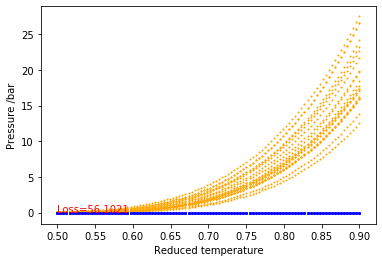

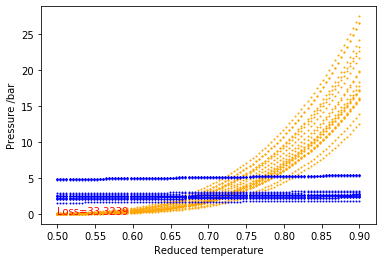

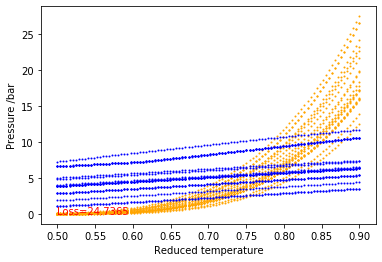

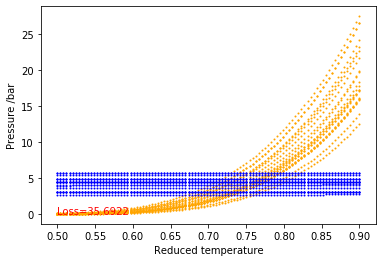

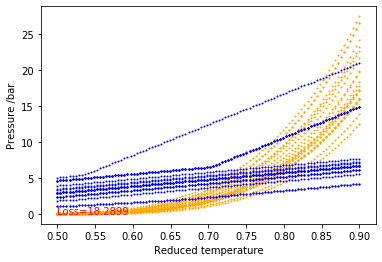

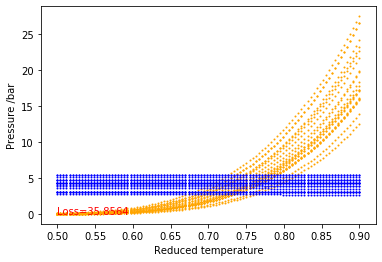

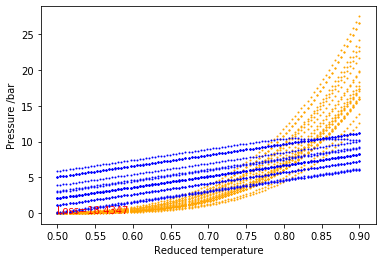

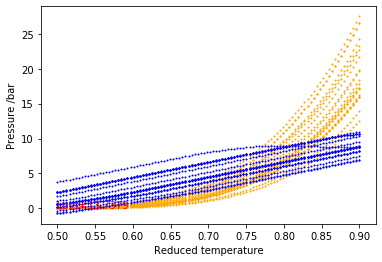

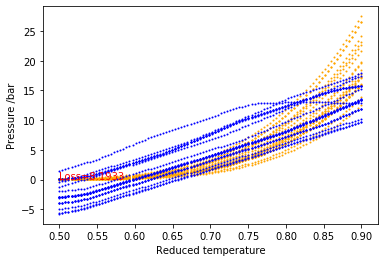

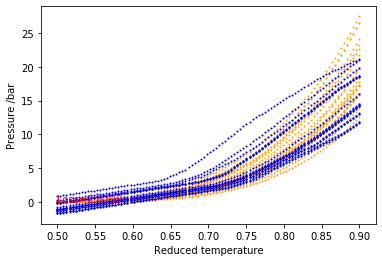

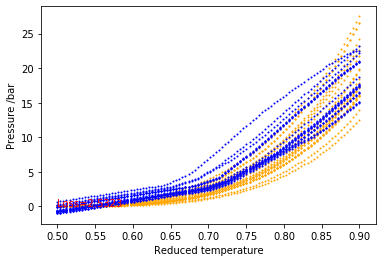

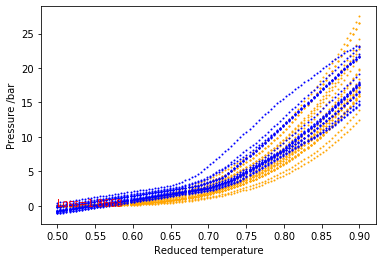

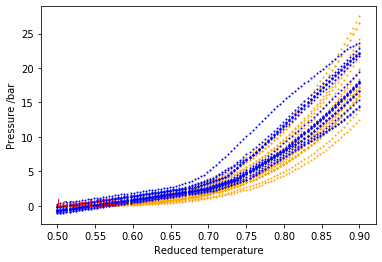

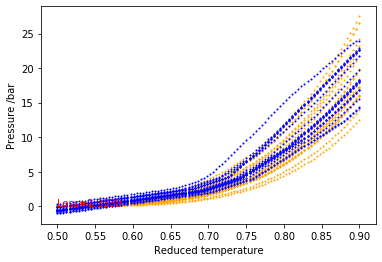

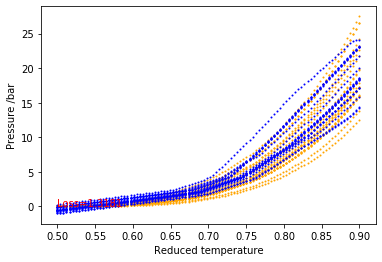

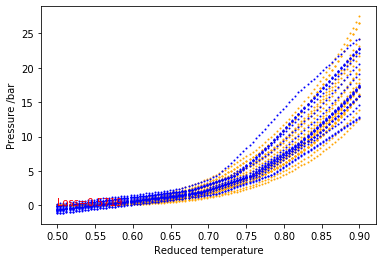

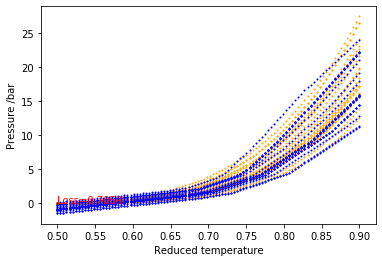

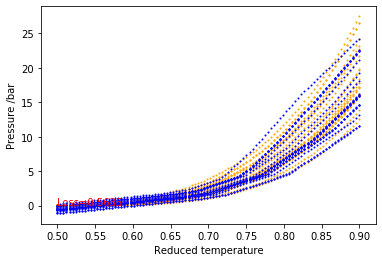

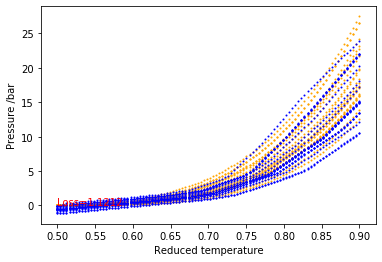

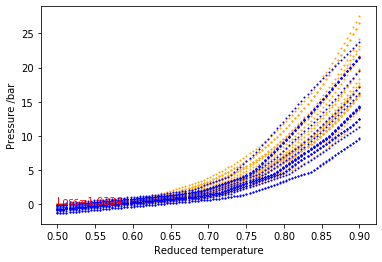

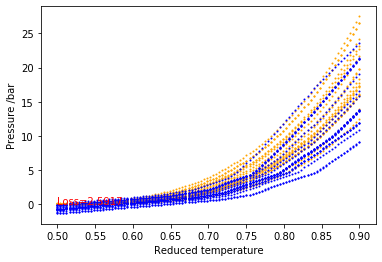

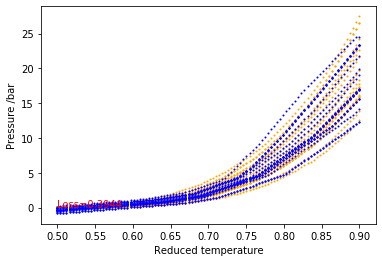

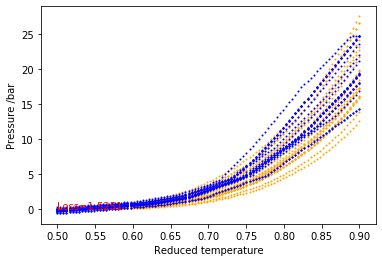

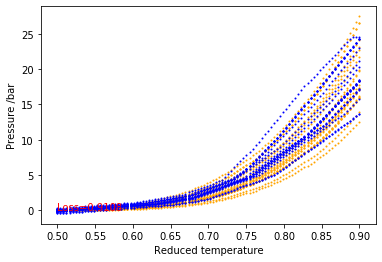

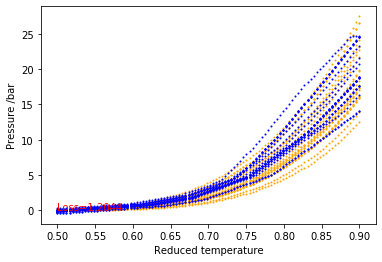

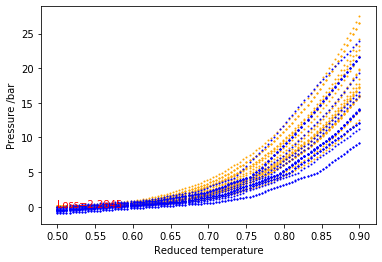

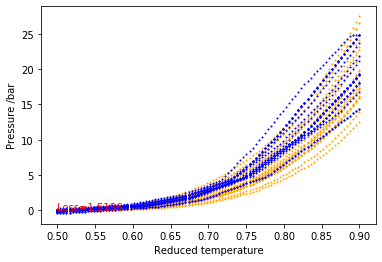

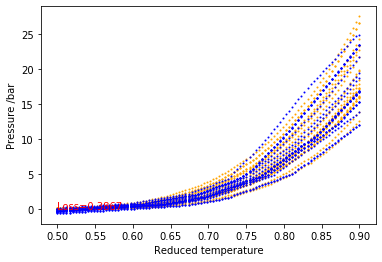

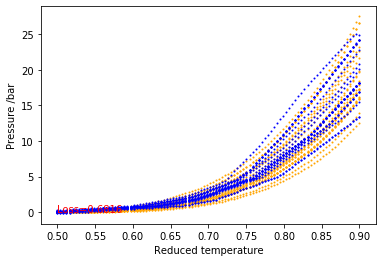

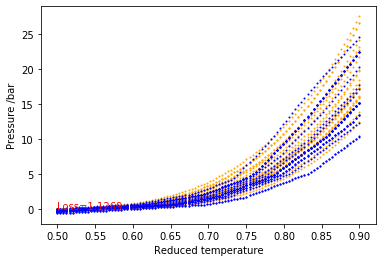

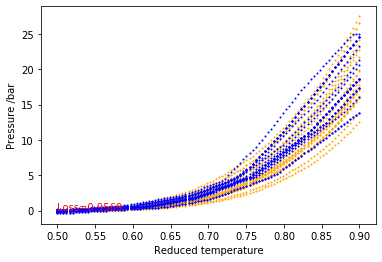

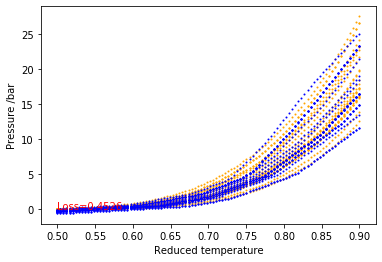

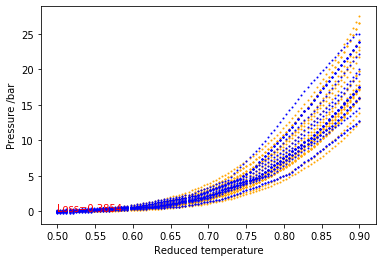

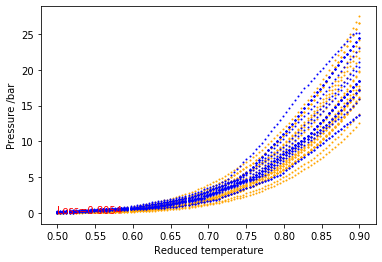

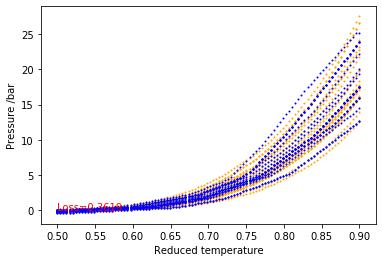

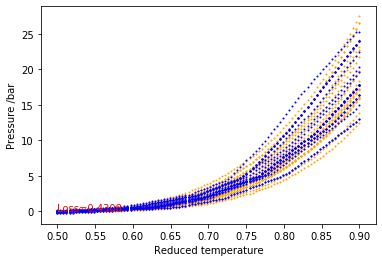

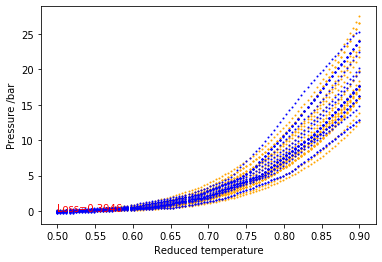

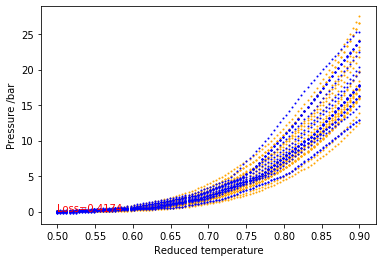

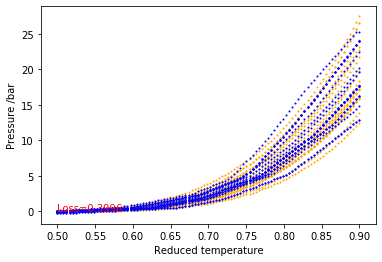

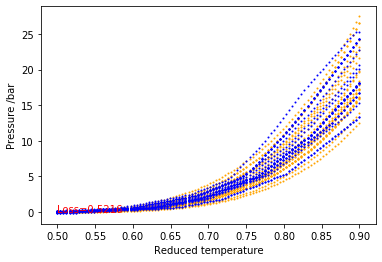

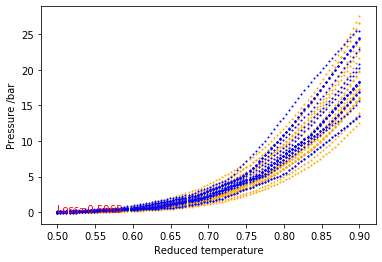

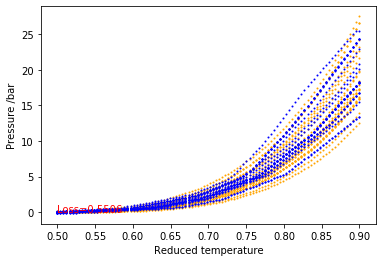

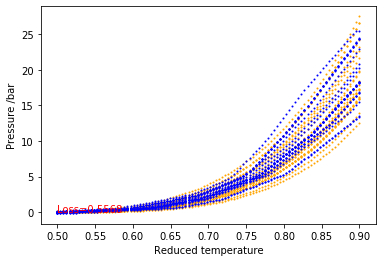

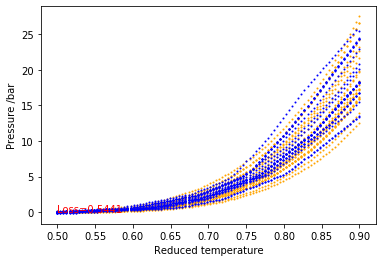

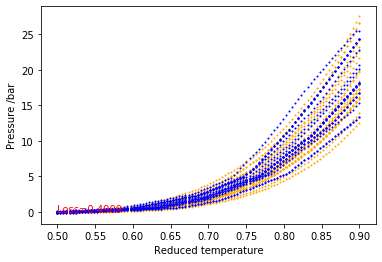

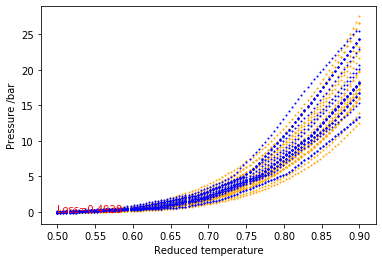

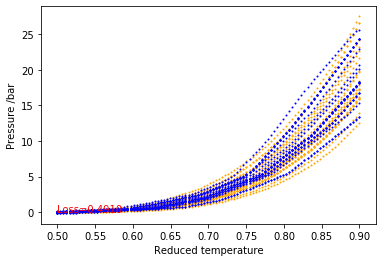

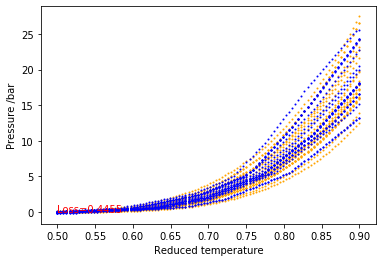

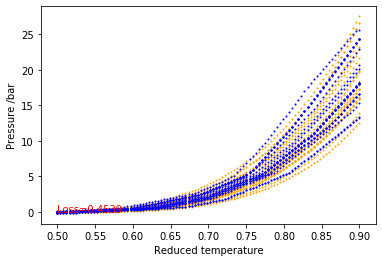

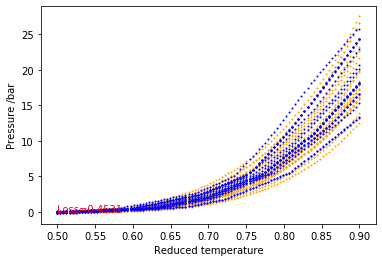

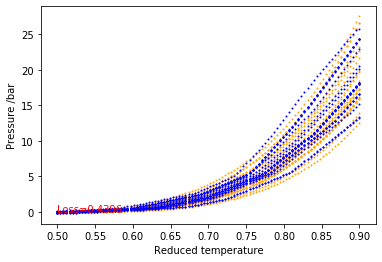

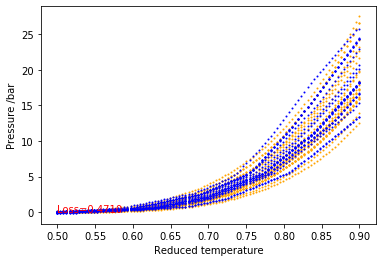

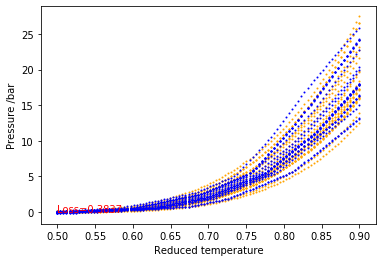

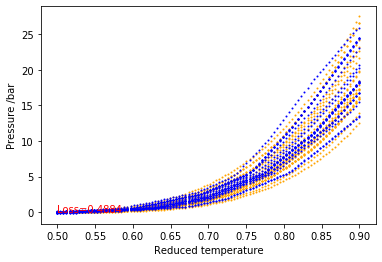

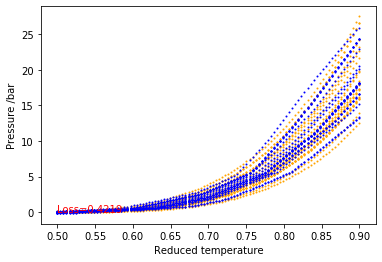

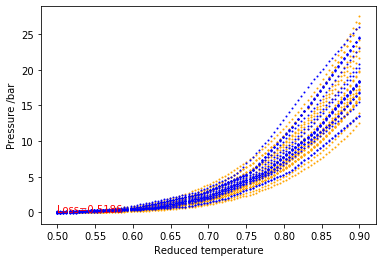

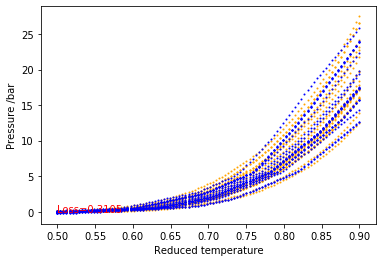

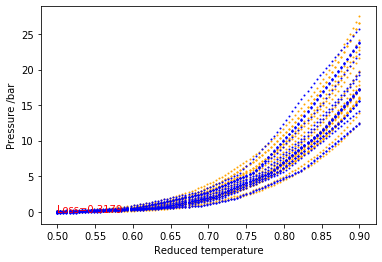

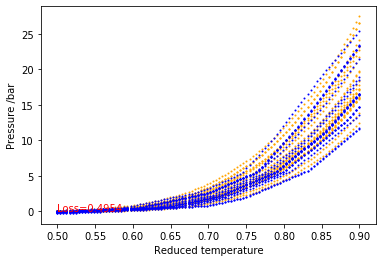

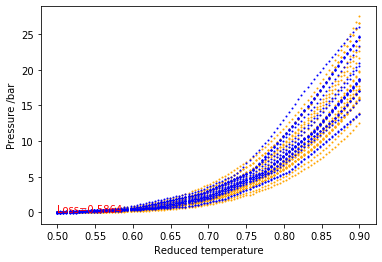

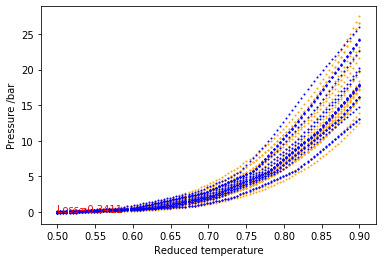

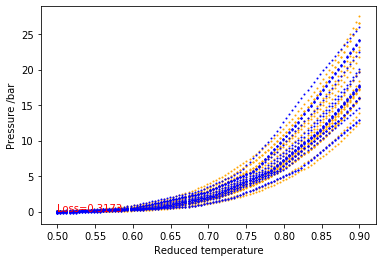

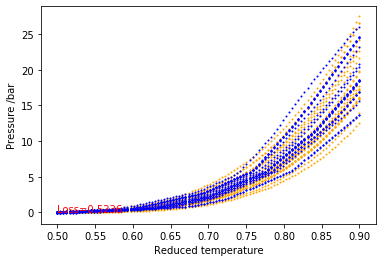

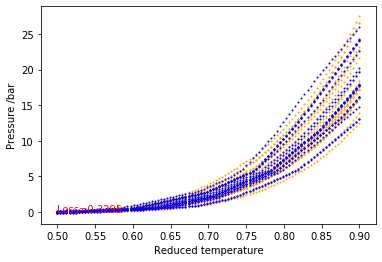

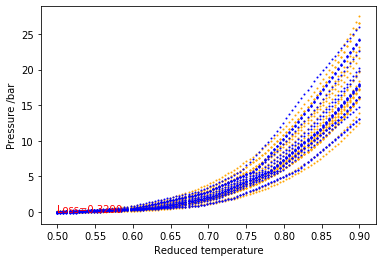

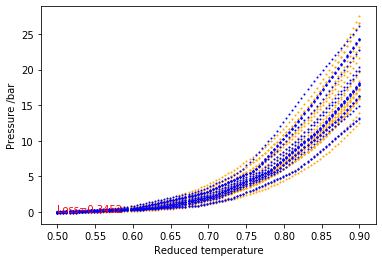

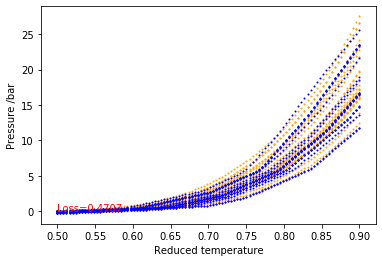

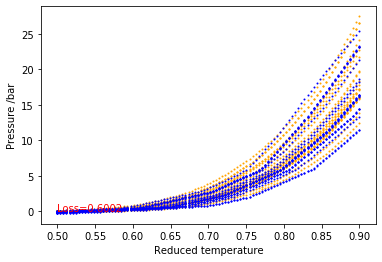

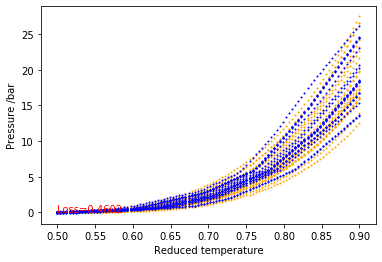

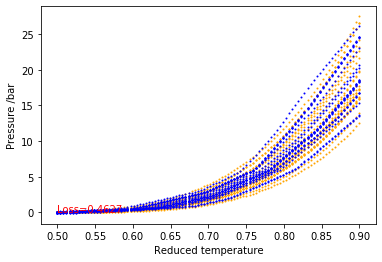

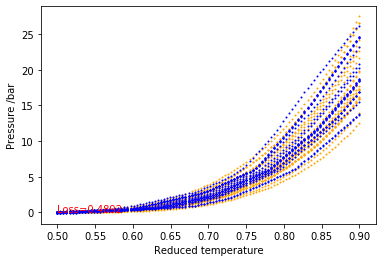

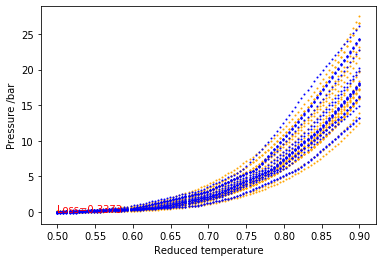

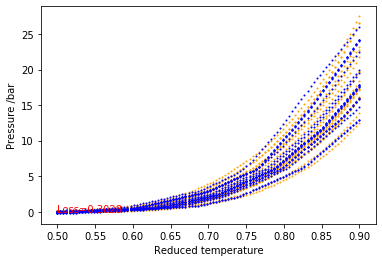

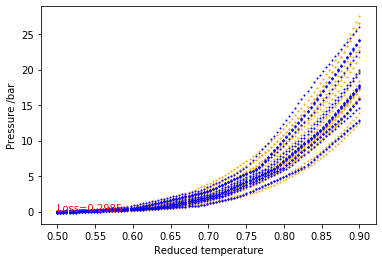

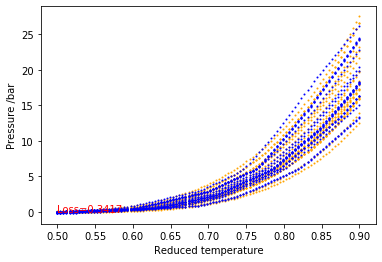

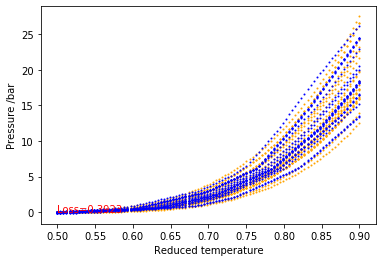

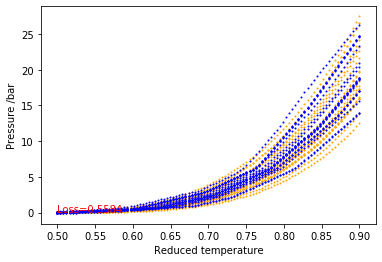

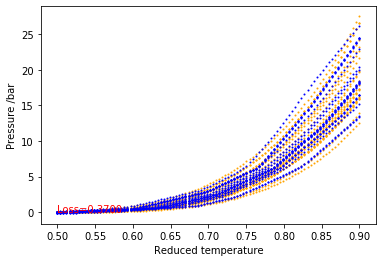

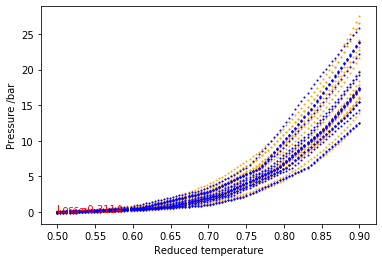

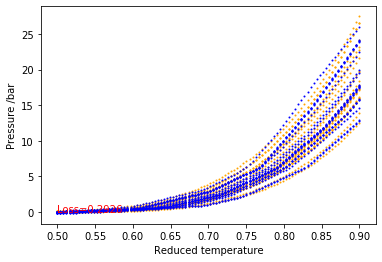

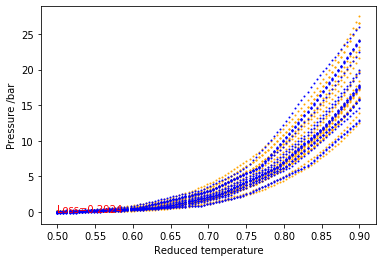

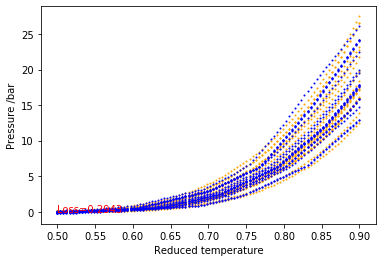

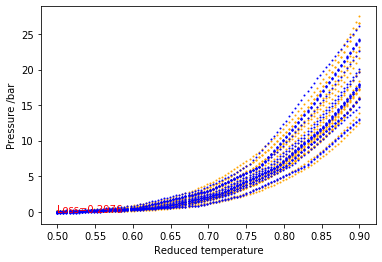

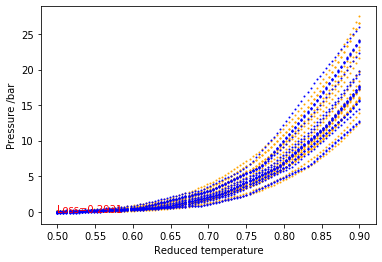

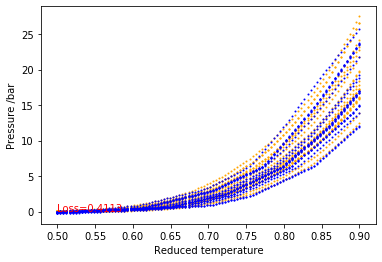

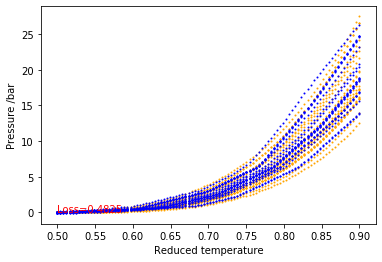

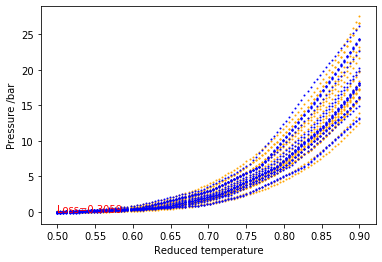

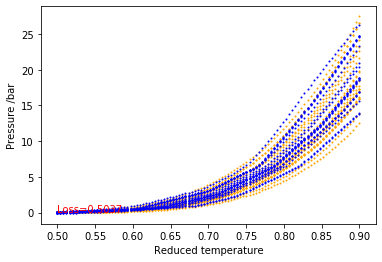

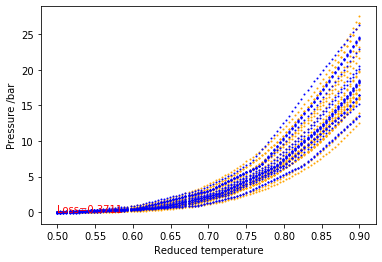

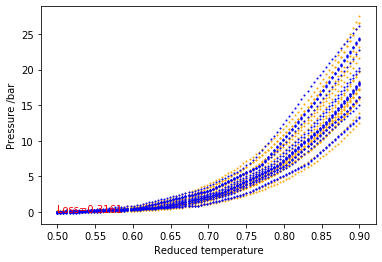

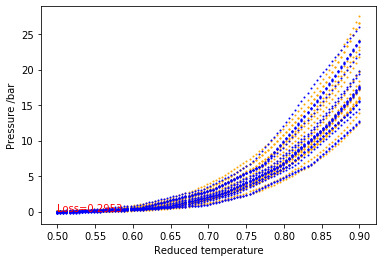

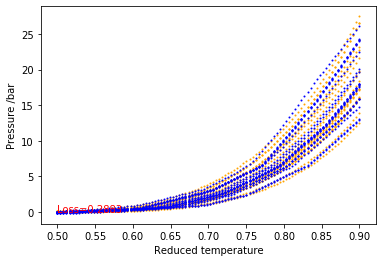

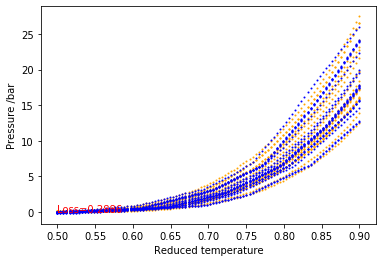

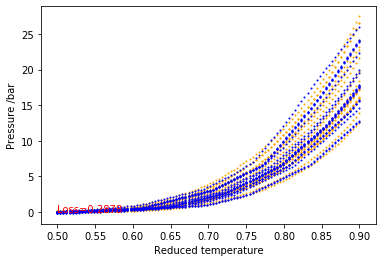

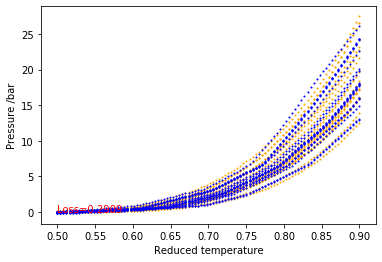

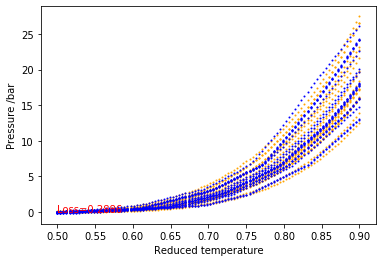

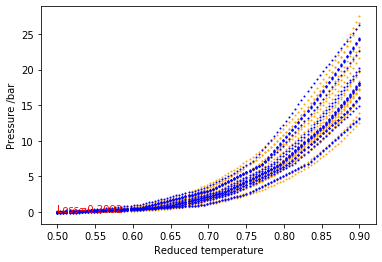

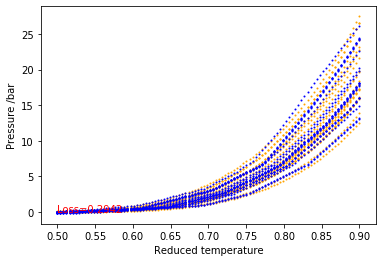

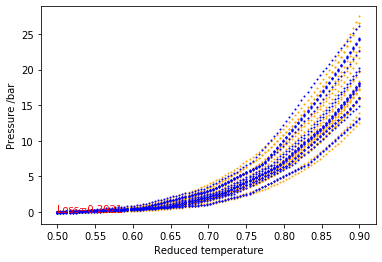

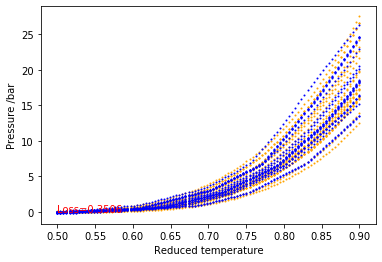

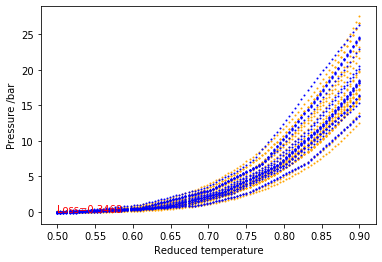

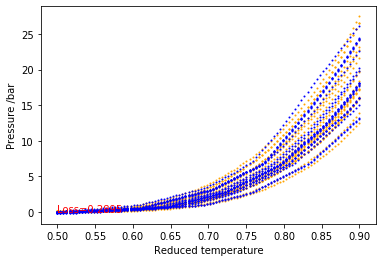

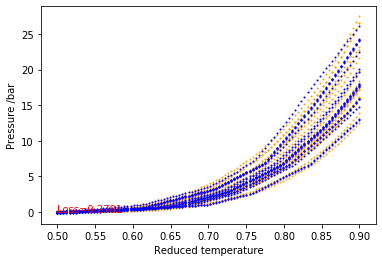

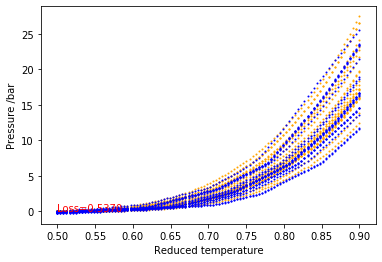

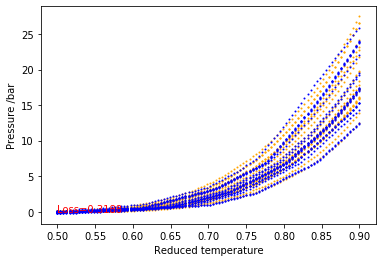

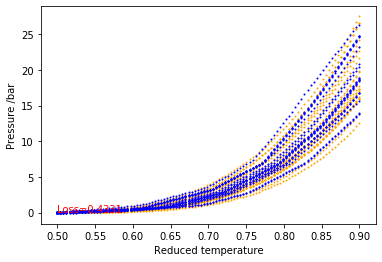

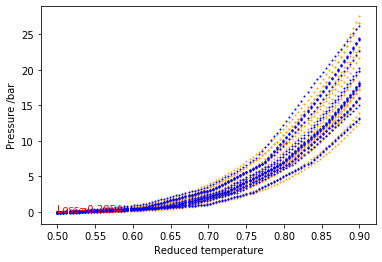

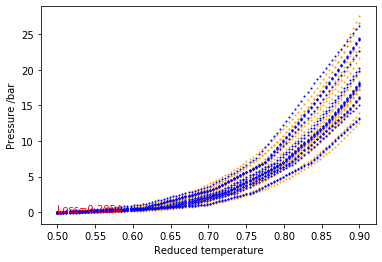

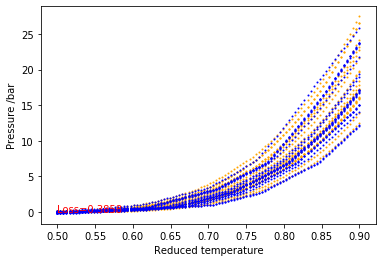

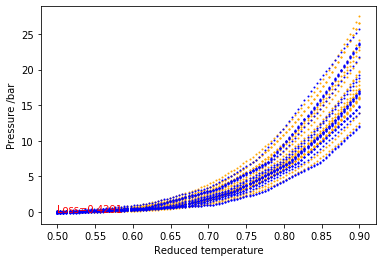

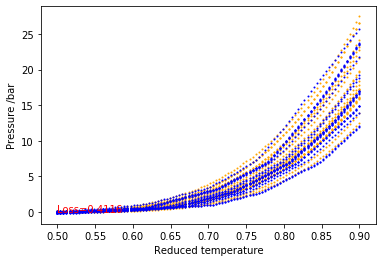

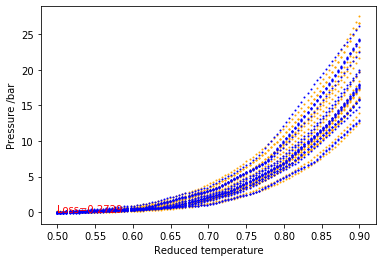

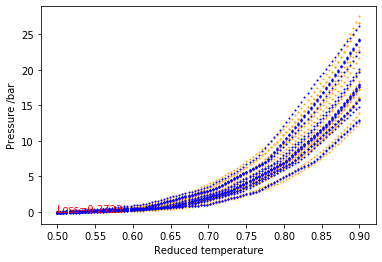

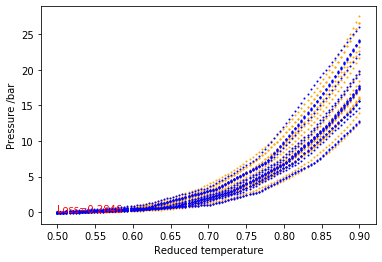

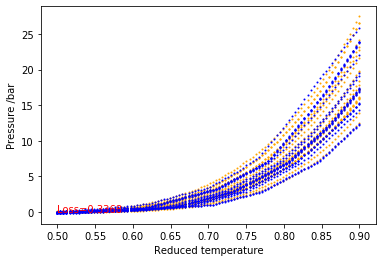

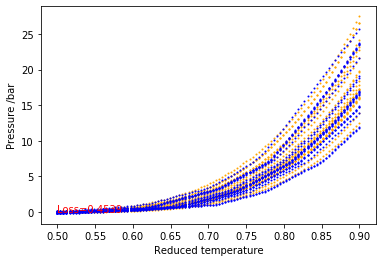

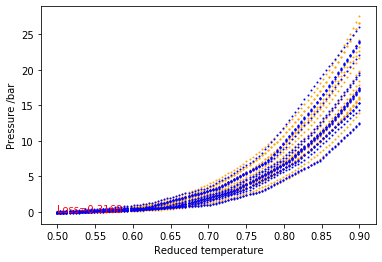

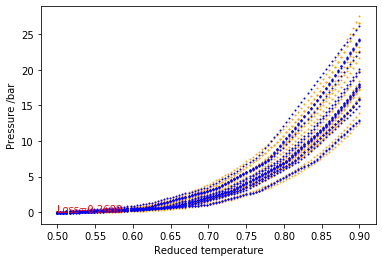

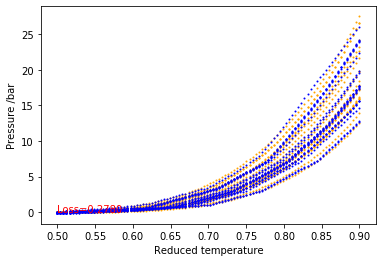

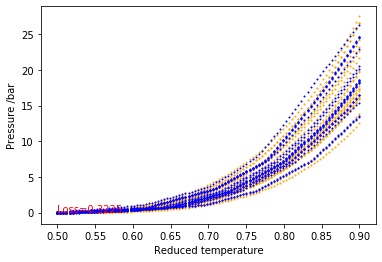

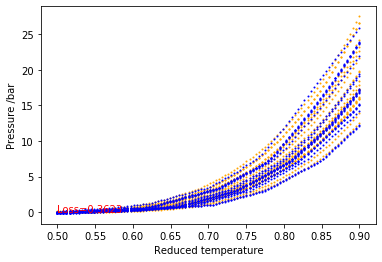

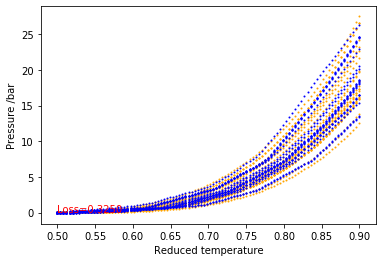

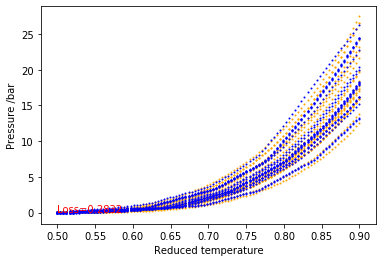

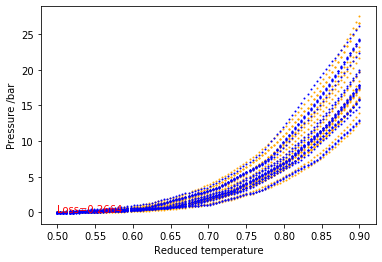

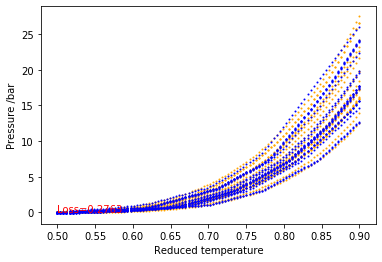

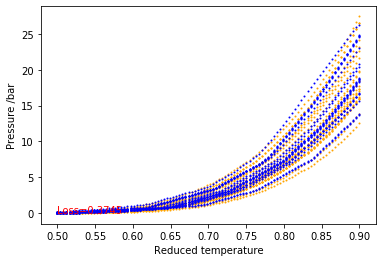

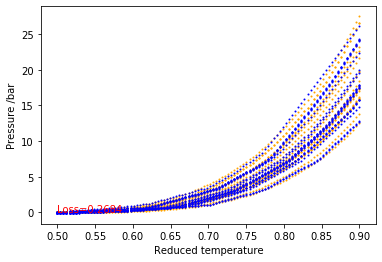

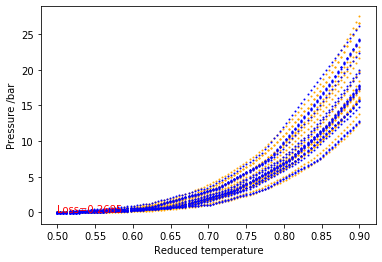

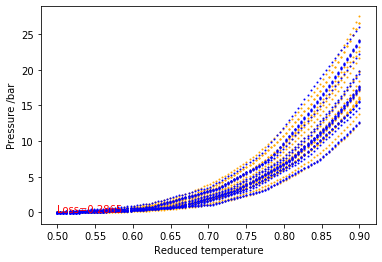

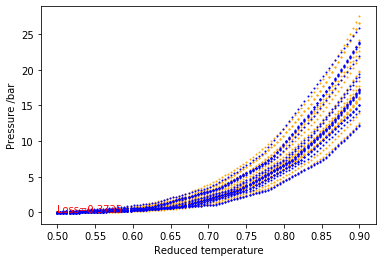

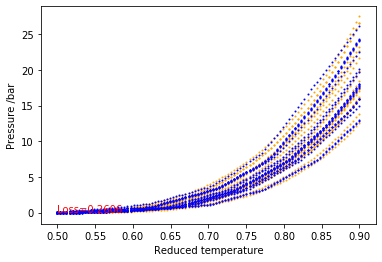

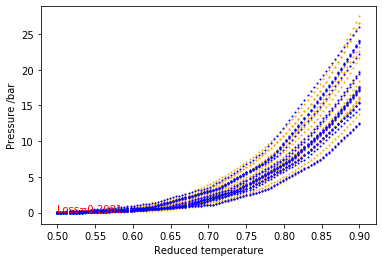

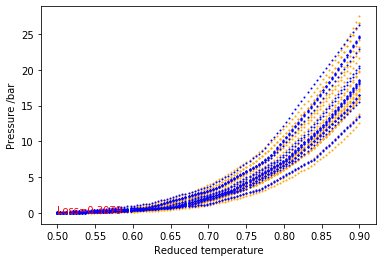

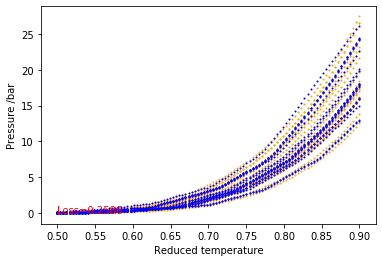

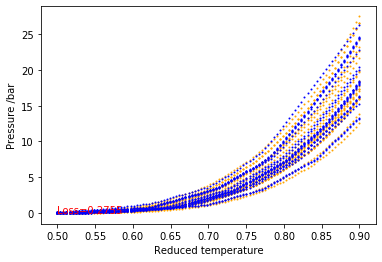

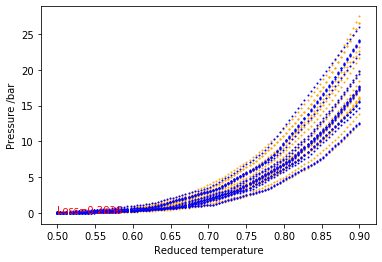

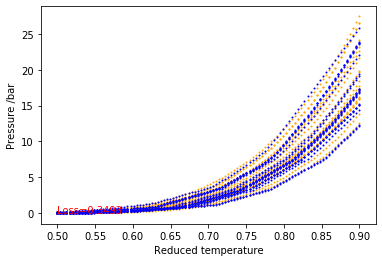

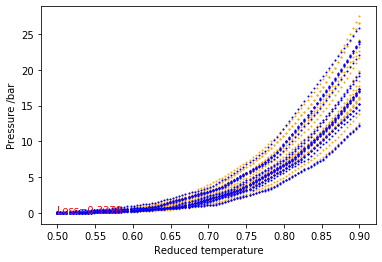

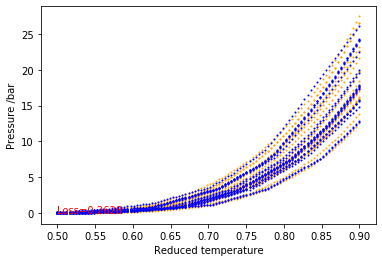

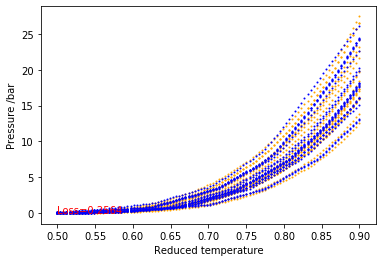

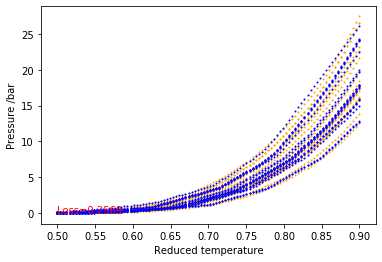

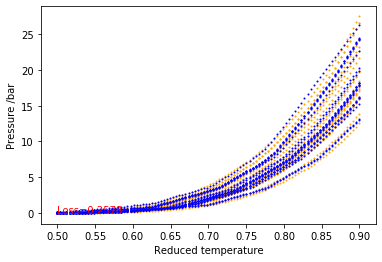

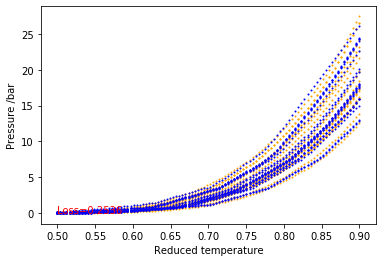

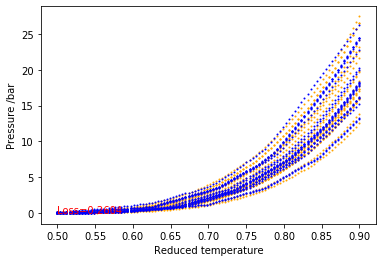

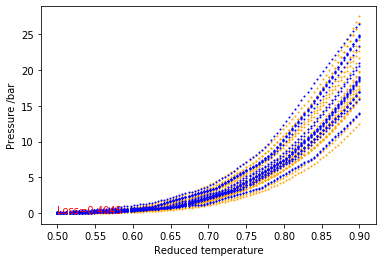

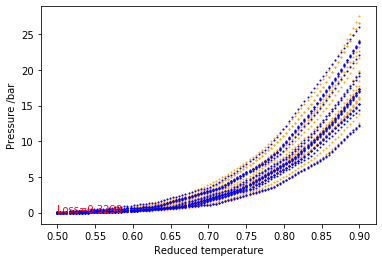

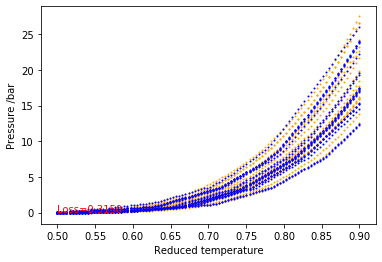

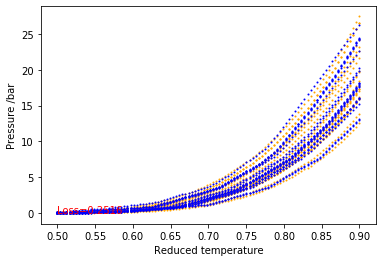

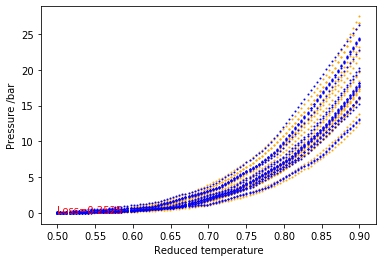

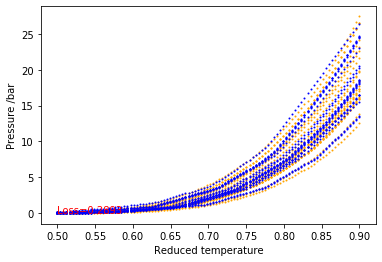

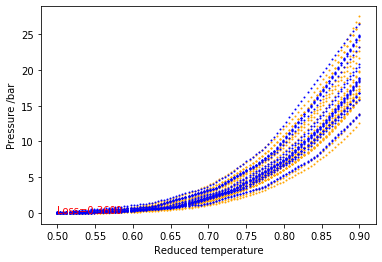

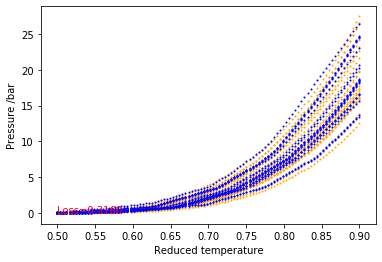

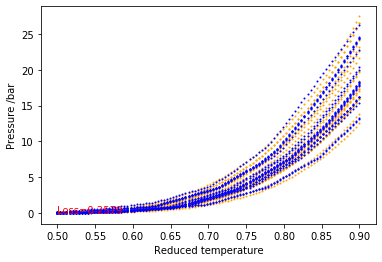

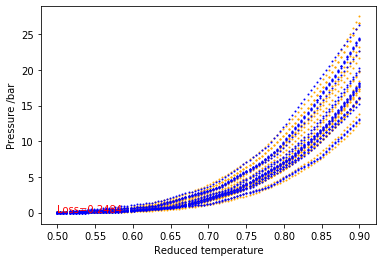

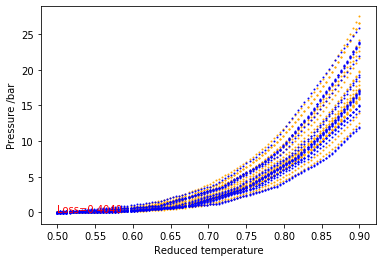

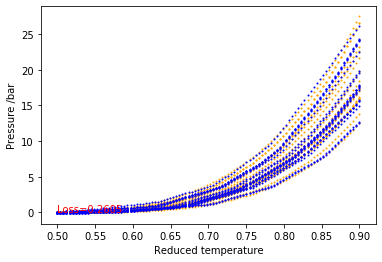

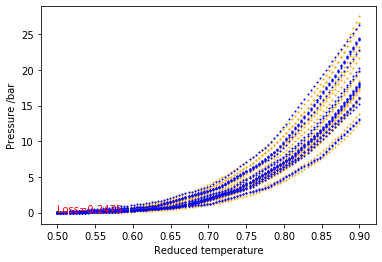

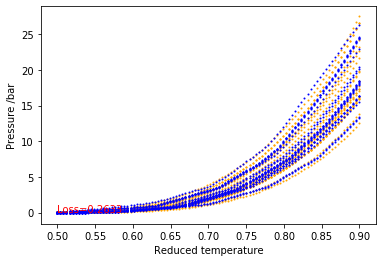

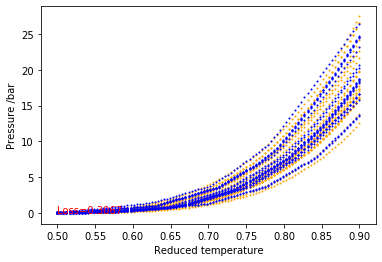

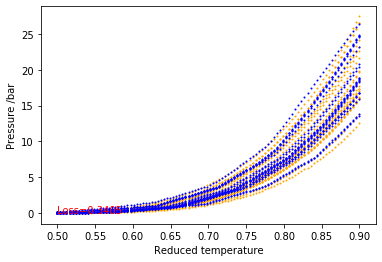

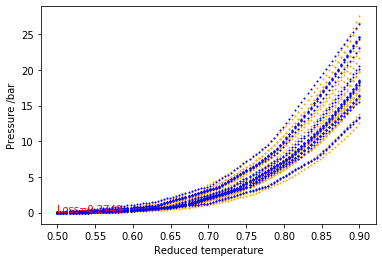

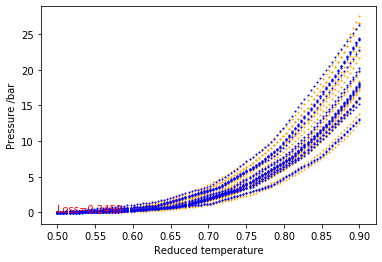

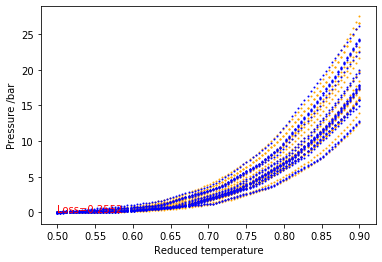

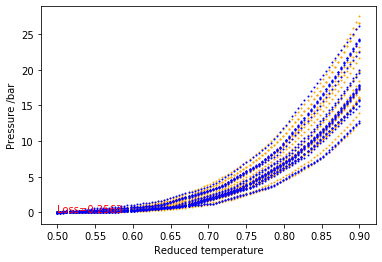

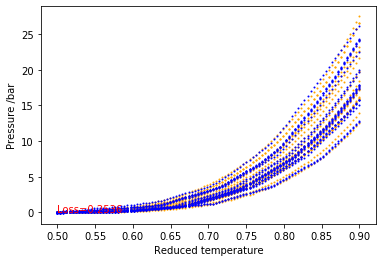

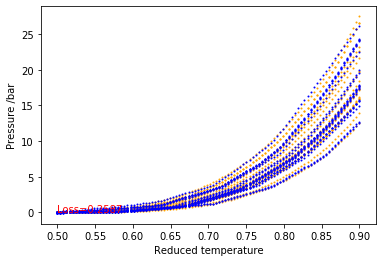

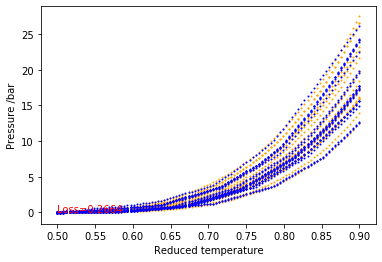

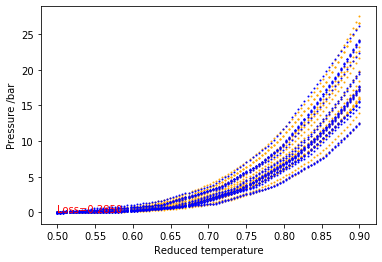

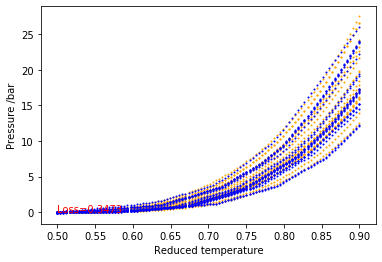

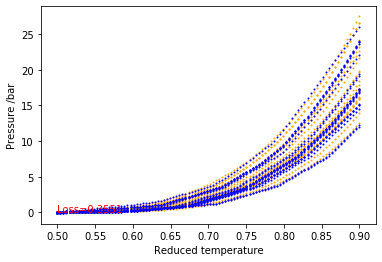

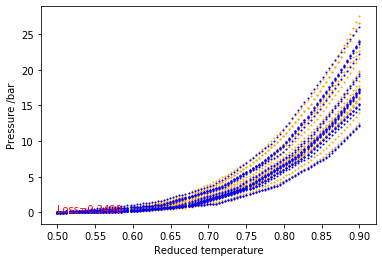

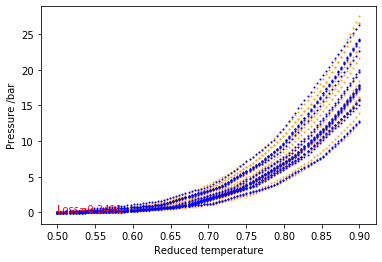

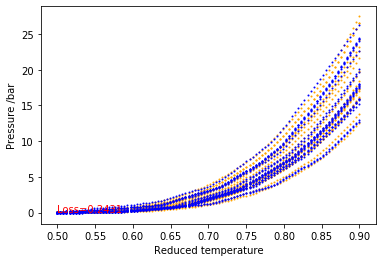

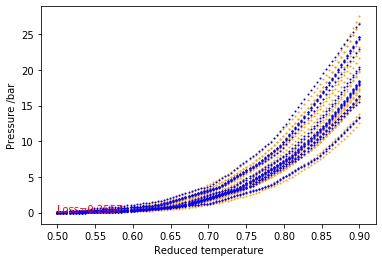

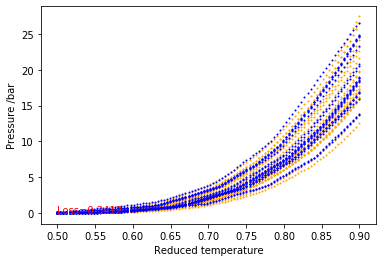

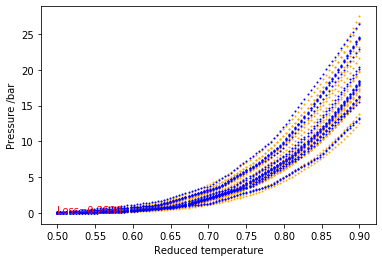

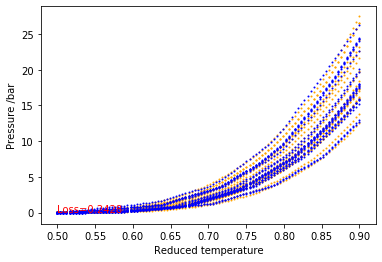

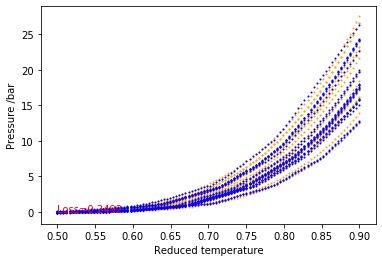

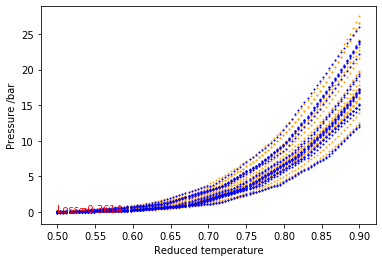

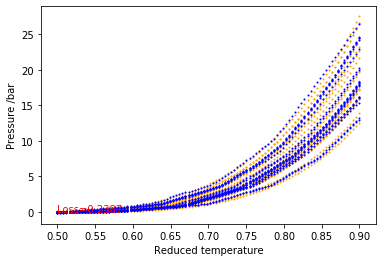

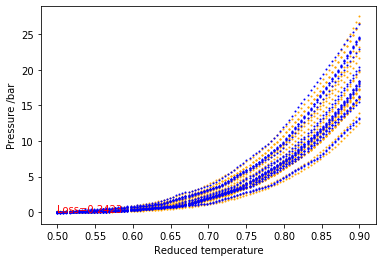

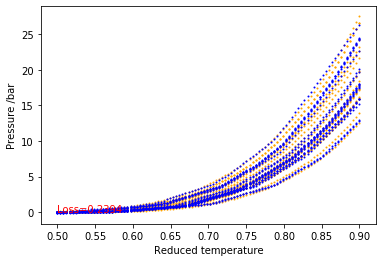

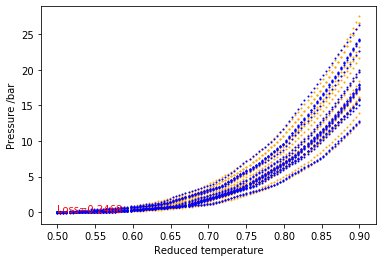

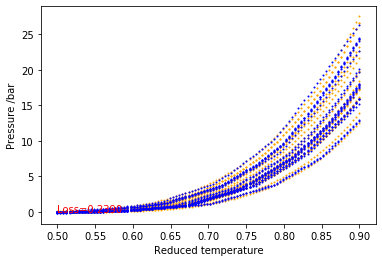

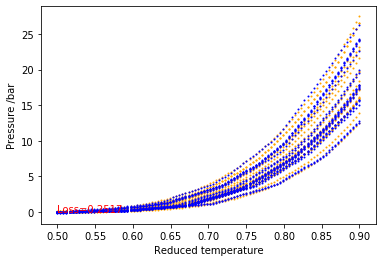

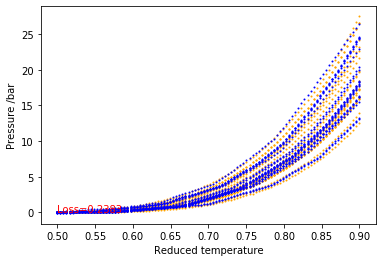

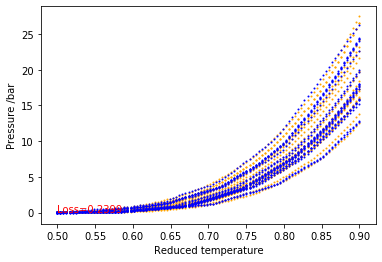

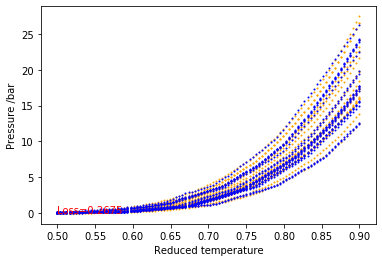

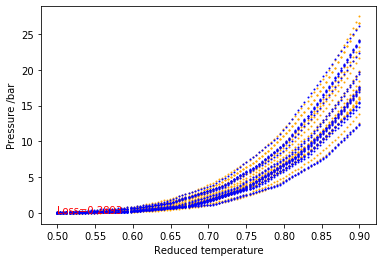

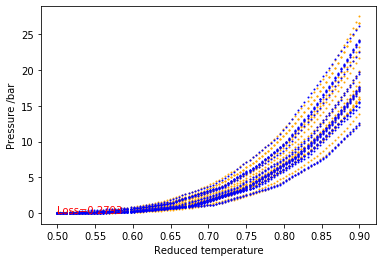

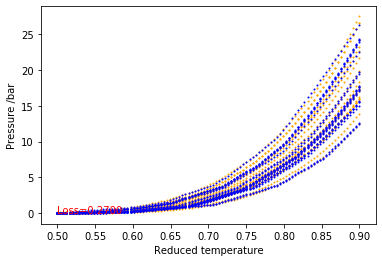

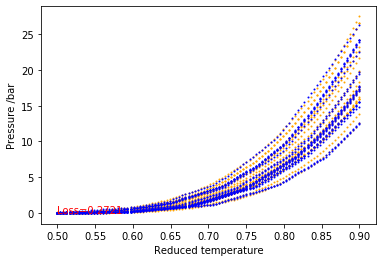

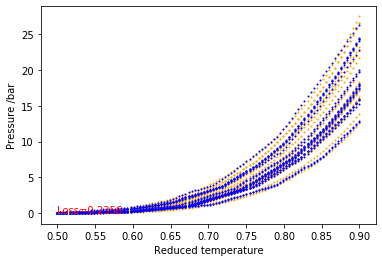

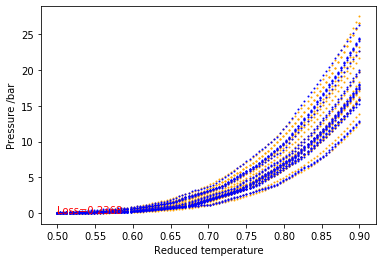

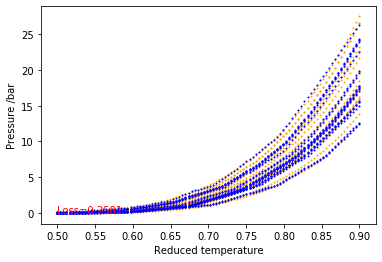

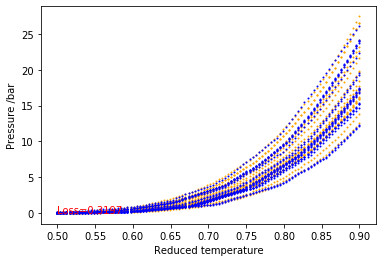

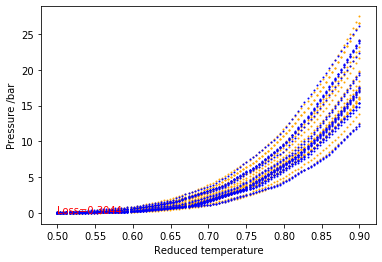

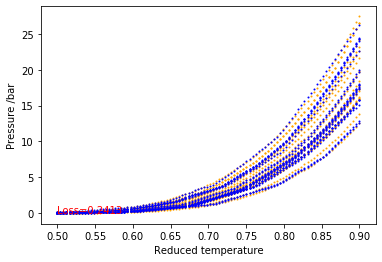

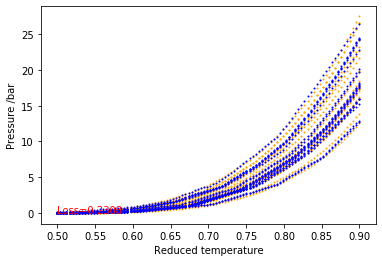

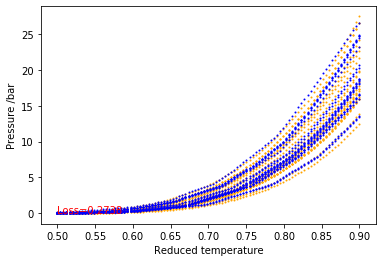

In [3]:
# extracting data

(data_headers, data_values) = data_extractor(filename='data_storage.xlsx')
r_names = data_values[np.where(data_headers == 'Refrigerant')[0][0]]
temp = data_values[np.where(data_headers == 'Temp /K')[0][0]]
temp_crit_saft = data_values[np.where(data_headers == 'Predicted crit temp /K')[0][0]]
omega = data_values[np.where(data_headers == 'Acentric factor')[0][0]]
spec_vol = data_values[np.where(data_headers == 'Spec vol /[m^3/mol]')[0][0]]
pressure = data_values[np.where(data_headers == 'Vapour pressure /Pa')[0][0]]
pressure = pressure/101300  # converting to bar
mol_weight = data_values[np.where(data_headers == 'Molecular weight')[0][0]]
num_C = data_values[np.where(data_headers == 'No. of C')[0][0]]
num_F = data_values[np.where(data_headers == 'No. of F')[0][0]]
num_CC = data_values[np.where(data_headers == 'No. of C=C')[0][0]]

reduced_temp = temp/temp_crit_saft
features = [mol_weight, reduced_temp, num_C, num_F, num_CC, omega]
labels = [pressure]


feature_matrix, label_matrix, training_range, test_range, validation_range = \
    nn_data_preparer(features, labels)
trained_nn = neural_network_trainer(feature_matrix, label_matrix, range(0, 2000), epochs=20000)

2.2049341201782227


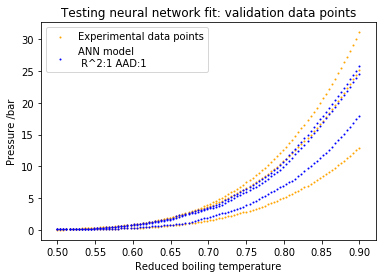

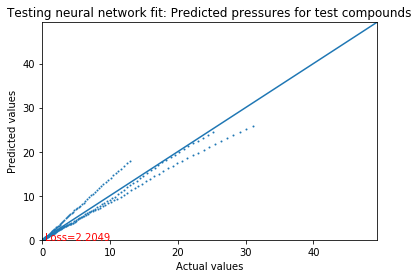

In [4]:
neural_network_evaluator(features, labels, range(2000, 2300), trained_nn)